# Import libraries and set configs

In [1]:
import sys
sys.path.append('..')

import os
import json
import joblib
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

from eli5.sklearn import PermutationImportance

import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

from colorama import Style, Fore

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval
from constants.constants import tv_username, tv_password


class CFG:
    load = False
    historical = False
    create_dataset = False
    cls_target_ratio_tp = 1.03
    cls_target_ratio_sl = 1.03
    ttype = 'both'
    patterns_to_filter = ['STOCH_RSI_Volume24']
    select_features = False
    optimize = False
    n_repeats = 1
    n_folds = 8
    agg_periods = [24, 168, 720]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

tqdm.pandas()

warnings.simplefilter(action='ignore', category=(FutureWarning, pd.errors.PerformanceWarning))

# Load data

### Load STOCH_RSI buy data

In [2]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'buy'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=True, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 31060

### Load STOCH_RSI sell data

In [3]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'sell'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 23629

# Test loaded data

### Remove dataframe files with the biggest number of missing data

In [4]:
counter = 0 

tickers_1h = glob('../optimizer/ticker_dataframes/*_1h.pkl')
for ticker in tqdm(tickers_1h[3:]):
    df = pd.read_pickle(ticker)
    nunique = df['time'].diff()[1:].nunique()
    if nunique > 1:
        count = df[df['time'].diff().astype('timedelta64[h]') != 1].shape[0]
        if count > 200:
            print(ticker, nunique, count)
            os.remove(ticker)
            os.remove(ticker[:-6] + '4h.pkl')
            
counter

  0%|          | 0/2335 [00:00<?, ?it/s]

0

### Plot time vs index for some of dataframe files

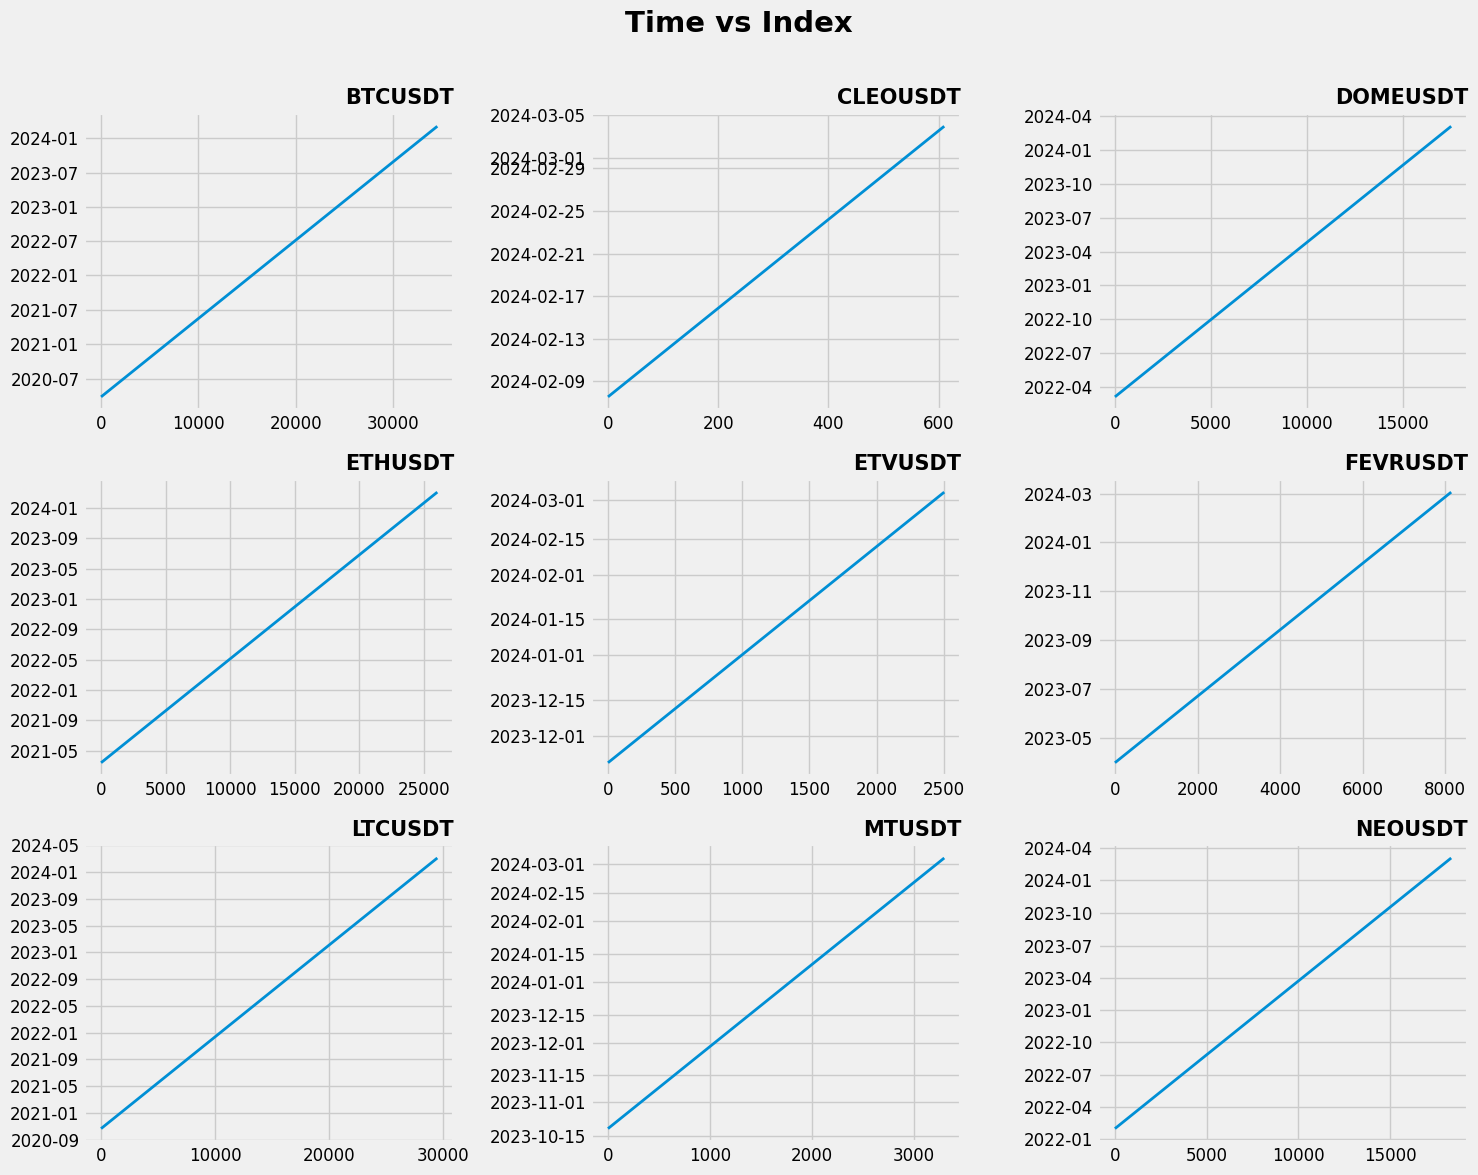

In [5]:
%matplotlib inline

n_cols = 3
n_rows = 3
figsize = (15, 4 * n_rows)

tickers = glob('../optimizer/ticker_dataframes/*_1h.pkl')
random_tickers = random.choices(tickers, k=n_cols*n_rows)
random_tickers[:3] = [t for t in tickers if '/BTCUSDT_1h' in t or '/ETHUSDT_1h' in t or '/LTCUSDT_1h' in t]

def plot_times(random_tickers, n_rows, n_cols):
    fig = plt.figure(figsize=figsize)
    
    for idx in range(n_cols*n_rows):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        df = pd.read_pickle(random_tickers[idx])
        sns.lineplot(data=df['time'])

        ax.set_ylabel('')
        plt.yticks(fontsize=12) 
        ax.set_xlabel('')
        plt.xticks(fontsize=12)
        # ax.spines['right'].set_visible(False)
        ax.set_title(f'{random_tickers[idx].split("/")[-1][:-7]}', loc='right', weight='bold', fontsize=15)
        ax.lines[0].set_linewidth(2)

    
    fig.suptitle(f'Time vs Index\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
plot_times(sorted(random_tickers),  n_rows=n_rows, n_cols=n_cols) 

### Check if all dataframe files has data for both timeframes 1h and 4h

In [6]:
import glob

x = glob.glob('../optimizer/ticker_dataframes/*.pkl')
y = [i[31:].split('_')[0] for i in x]
z = ('').join(x)

for i in y:
    if f'{i}_1h' not in z:
        print(i, '1h')
    if f'{i}_4h' not in z:
        print(i, '4h')

# Prepare and create train data

### Functions

In [7]:
# Get configs
configs = ConfigFactory.factory(environ).configs

higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist', 'macdsignal']
price_cols = ['open','high', 'low', 'close']
real_price_cols = ['real_high', 'real_low', 'real_close']
funding_cols = ['funding_rate']
rsi_stoch_cols = ['rsi', 'stoch_diff', 'stoch_slowd', 'stoch_slowk']
btcd_cols = ['time', 'btcd_open', 'btcd_high', 'btcd_low', 'btcd_close', 'btcd_volume']
btcdom_cols = ['time', 'btcdom_open', 'btcdom_high', 'btcdom_low', 'btcdom_close', 'btcdom_volume']

def get_file(ticker):
    ''' Find files buy ticker names '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h

def add_indicators(df, df_higher, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, '', '', 0)
    # merge higher timeframe indicators with working timeframe
    df_higher['time'] = df_higher['time'] + pd.to_timedelta(3, unit='h')
    df[higher_features] = pd.merge(df[['time']], df_higher[higher_features], how='left', on='time')
    df.drop(columns=['close_smooth'], inplace=True)
    df.drop(columns=[c for c in df.columns if c.endswith('_dir')], inplace=True)
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[['time']], btcd[btcd_cols], how='left', on='time')
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[['time']], btcdom[btcdom_cols], how='left', on='time')
    df.ffill(inplace=True)
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # price and MACD columns to pct difference
    df[real_price_cols] = df[['high', 'low', 'close']]
    cols_to_scale = ['open', 'high', 'low', 'close', 'macd', 'macdhist', 'macdsignal', 'atr']
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    return df.reset_index(drop=True)


def create_train_df(df, ttype, configs, target_offset, first, last, step):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    # tickers = ['ZILUSDT'] # !!!
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f'TypeError, ticker - {ticker}')
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            pass_cycle, sl = False, False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            # if t.year == 2024 and t.month == 2 and t.day == 15 and t.hour == 22: # !!!
            #     pass
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row['ticker'] = ticker
                row['pattern'] = pattern
                
            if pass_cycle:
                continue

            row['target'] = 0
            row['ttype'] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith('MACD'):
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t + timedelta(hours=3), 'real_close']
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t, 'real_close']

            # move to the next ticker if can't find any data corresponding to time t
            if close_price.shape[0] == 0:
                break
            
            close_price = close_price.values[0]
            
            for i in range(1, target_offset + 1):
                if pattern.startswith('MACD'):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                    
                target_buy = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_high']
                target_sell = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_low']
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                # set 
                higher_price = close_price * CFG.cls_target_ratio_tp
                lower_price = close_price * (2 - CFG.cls_target_ratio_tp)
                target_buy_tp = 1 if target_buy > higher_price else 0
                target_buy_sl = 1 if target_buy > higher_price else 0
                target_sell_tp = 1 if target_sell < lower_price else 0
                target_sell_sl = 1 if target_sell < lower_price else 0

                pattern = row['pattern'].values[0]
                ttype = row['ttype'].values[0]
                
                # set SL flag and exit cycle if price reaches stop-loss threshold before it reaches take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith('STOCH') and ttype == 'buy' and target_buy_sl == 1
                sl2 = pattern.startswith('STOCH') and ttype == 'sell' and target_sell_sl == 1

                # set TP flag and exit cycle if price reaches take-profit threshold and doesn't reach stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith('STOCH') and ttype == 'buy' and target_sell_tp == 1
                tp2 = pattern.startswith('STOCH') and ttype == 'sell' and target_buy_tp == 1
                    
                # if both TP and SL flag is on - don't consider that trade
                if (tp1 and sl1) or (tp2 and sl2):
                    pass_cycle = True
                    break
                elif sl1 or sl2:
                    break
                elif tp1 or tp2:
                    row['target'] = 1
                    break
                
                # if price doesn't reaches both TP and SL thresholds but price above / below enter price for buy / sell trade - set TP flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_close'].values[0]
                    l1 = pattern.startswith('STOCH') and ttype == 'buy' and last_price < close_price
                    l2 = pattern.startswith('STOCH') and ttype == 'sell' and last_price > close_price

                    if l1 or l2:
                        row['target'] = 1
            
            if pass_cycle:
                continue

            # add aggregates
            # for col in ['open', 'close', 'low', 'high', 'volume']:
            #     for period in CFG.agg_periods:
            #         for agg_func in CFG.agg_funcs:
            #             tmp_len = min(len(tmp_df_1h), period)
            #             stat_val = tmp_df_1h.iloc[-tmp_len:, tmp_df_1h.columns.get_loc(col)].rolling(period, min_periods=1).agg({'func': agg_func}).values[-1, 0]
            #             row[f'{col}_{agg_func.__name__}_{period}'] = stat_val
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = row
            else:
                train_df = pd.concat([train_df, row])
    
    train_df = train_df.drop(columns=real_price_cols)
    return train_df


### Prepare train data

In [8]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 272
# for how long time (in hours) we want to predict
target_offset = 96

if CFG.create_dataset:
    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist('BTC.D','CRYPTOCAP', interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns='symbol')
    btcd.columns = btcd_cols
    btcd['time'] = btcd['time'] + pd.to_timedelta(23, unit='h')

    btcdom = tv.get_hist('BTCDOMUSDT.P','BINANCE', interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns='symbol')
    btcdom.columns = btcdom_cols
    btcdom['time'] = btcdom['time'] + pd.to_timedelta(3, unit='h')
    
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    buy_hours_to_save = [0, 1, 2, 3, 16, 17, 21, 22, 23]
    df = df[df['time'].dt.hour.isin(buy_hours_to_save)]
    # dataset for model train
    train_buy = create_train_df(df, 'buy', configs, target_offset, first, last, step)
    train_buy = train_buy.dropna()
    train_buy.to_pickle(f'signal_stat/train_buy_{last}.pkl')

    display(train_buy.head())
    display(train_buy.shape)

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    sell_hours_to_save = [1, 4, 14, 16, 17, 18, 19, 21, 22, 23] # 22 !!!
    df = df[df['time'].dt.hour.isin(sell_hours_to_save)]
    # dataset for model train
    train_sell = create_train_df(df, 'sell', configs, target_offset, first, last, step)
    train_sell = train_sell.dropna()
    train_sell.to_pickle(f'signal_stat/train_sell_{last}.pkl')

    # this is made for tests
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]

    test_df_buy_1 = df[df['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    test_df_buy_1 = create_train_df(test_df_buy_1, 'buy', configs, target_offset, first, last, step)
    test_df_buy_1 = test_df_buy_1.dropna().sort_values('time').reset_index(drop=True)

    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    
    test_df_sell_1 = df[df['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    test_df_sell_1 = create_train_df(test_df_sell_1, 'sell', configs, target_offset, first, last, step)
    test_df_sell_1 = test_df_sell_1.dropna().sort_values('time').reset_index(drop=True)

    del df

    display(train_sell.head())
    display(train_sell.shape)

### Create train dataset

In [9]:
train_buy = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
train_sell = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')

train_df = pd.concat([train_buy, train_sell])
train_df = train_df.sort_values('time')

# do not consider the last signals - they may contain erroneus signals
train_df = train_df[train_df['time'] < train_df['time'].max()].reset_index(drop=True)


# Data tests

### Test train dataframe columns

In [10]:
import re

if CFG.create_dataset:

    # check if train dataset has only columns that we expect
    cols = set(re.sub(r'_prev_\d+', '', c) for c in train_buy.columns)
    expected_cols = set(price_cols + higher_features + funding_cols + rsi_stoch_cols +
                        btcd_cols + btcdom_cols + ['atr', 'pattern', 'target', 'ticker', 'ttype', 'volume'])
    assert expected_cols == cols

    # check RSI and STOCH columns, their values must be in [0, 100] range 
    rsi_stoch_cols_ = [c for c in train_df.columns if ('rsi' in c or 'stoch' in c) and 'diff' not in c]
    for r_s_c in rsi_stoch_cols_:
        assert train_df[r_s_c].min() > -0.0001
        assert train_df[r_s_c].max() < 100.0001

    # check volume columns, their values must be >= 0
    vol_cols_ = [c for c in train_df.columns if 'volume' in c]
    for v_c in vol_cols_:
        assert train_df[v_c].min() >= 0

    # check funding columns, their period must be 8 hours
    funding_cols_ = [c for c in train_df.columns if c.startswith('funding')]
    for f_c in funding_cols_:
        num = ''.join([i for i in f_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 8 == 0

    # check BTC dominance columns, their values must be in [0, 100] range 
    # and their period must be 24 hours
    btcd_cols_ = [c for c in train_df.columns if c.startswith('btcd_') and 'volume' not in c]
    for b_c in btcd_cols_:
        # check values
        assert train_df[b_c].min() >= 0
        assert train_df[b_c].max() <= 100
        # check period
        num = ''.join([i for i in b_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 24 == 0

    # check the rest columns, their period must be 4 hours
    rest_cols_ = [c for c in train_df.columns if c not in funding_cols_ and c not in btcd_cols]
    for r_c in rest_cols_:
        num = ''.join([i for i in r_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 4 == 0

    # check if changing of source dataframe doesn't affect the resulting train dataframe
    test_df_buy_2 = train_buy[train_buy['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    assert test_df_buy_1.shape == test_df_buy_2.shape
    test_df_sell_2 = train_sell[train_sell['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    assert test_df_sell_1.shape == test_df_sell_2.shape

    # plot time values 
    train_df['time'].plot(title='Signal Time distribution')


### Test buy target corectness

In [11]:
prev_ticker = None

if CFG.create_dataset:
    for i in tqdm(range(train_buy.shape[0])):
        x = train_buy[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        
        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'): 
                if last_price < close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

### Test sell target corectness

In [12]:
if CFG.create_dataset:
    for i in tqdm(range(train_sell.shape[0])):
        x = train_sell[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']

        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'):
                if last_price > close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

### Test pattern / target distribution

In [13]:
def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row['total'], row['count']
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

pvt = train_buy
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt.rename(columns={'pattern': 'count'}, inplace=True)
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Buy')
display(pvt)
display(train_buy['ttype'].value_counts())
display(train_buy[['target', 'pattern']].value_counts())
display(train_buy[['target', 'pattern']].value_counts(normalize=True))

pvt = train_sell
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt.rename(columns={'pattern': 'count'}, inplace=True)
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Sell')
display(pvt)
display(train_sell['ttype'].value_counts())
display(train_sell[['target', 'pattern']].value_counts())
display(train_sell[['target', 'pattern']].value_counts(normalize=True))

Buy


,hour,target,count,total,pct,trust_interval
1,0,1,691,1238,0.558158,"(0.5306, 0.5857)"
3,1,1,865,1603,0.539613,"(0.5153, 0.5639)"
5,2,1,816,1523,0.535785,"(0.5109, 0.5607)"
7,3,1,936,1789,0.523197,"(0.5002, 0.5462)"
9,16,1,768,1410,0.544681,"(0.5188, 0.5705)"
11,17,1,750,1439,0.521195,"(0.4955, 0.5469)"
13,21,1,791,1463,0.540670,"(0.5153, 0.5661)"
15,22,1,825,1478,0.558187,"(0.533, 0.5834)"
17,23,1,722,1264,0.571203,"(0.5441, 0.5983)"


buy    13207
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    7164
0       STOCH_RSI_Volume24    6043
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.54244
0       STOCH_RSI_Volume24    0.45756
dtype: float64

Sell


,hour,target,count,total,pct,trust_interval
1,1,1,475,901,0.527192,"(0.4948, 0.5596)"
3,4,1,745,1394,0.534433,"(0.5084, 0.5605)"
5,14,1,726,1343,0.540581,"(0.5141, 0.5671)"
7,16,1,574,1088,0.527574,"(0.4981, 0.5571)"
9,17,1,516,913,0.565170,"(0.5332, 0.5972)"
11,18,1,446,839,0.531585,"(0.498, 0.5652)"
13,19,1,468,873,0.536082,"(0.5032, 0.569)"
15,21,1,511,933,0.547696,"(0.5159, 0.5795)"
17,22,1,468,878,0.533030,"(0.5002, 0.5659)"
19,23,1,515,930,0.553763,"(0.522, 0.5855)"


sell    10092
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    5444
0       STOCH_RSI_Volume24    4648
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.539437
0       STOCH_RSI_Volume24    0.460563
dtype: float64

# Data visualization

### Plot ratio of class 1 for every month

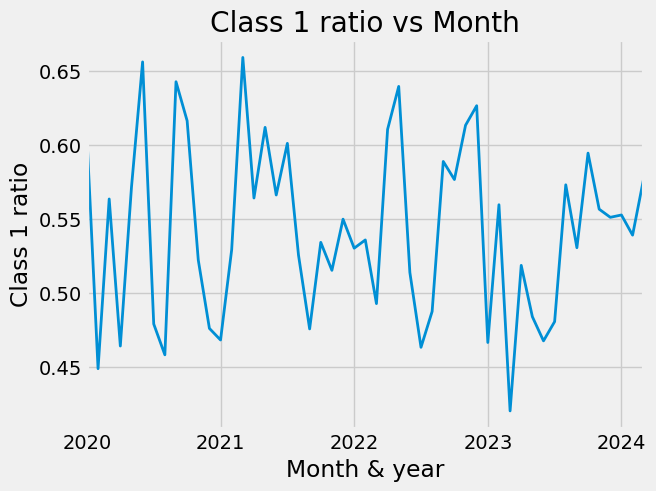

In [14]:
train_df['date_month'] = train_df['time'].dt.to_period('M')
group_df = train_df[train_df['time'].dt.year >= 2020]
ax = group_df.groupby('date_month')['target'].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel('Month & year')
ax.set_ylabel('Class 1 ratio')
ax.set_title('Class 1 ratio vs Month')
train_df = train_df.drop(columns='date_month')

### Visualize buy trades

In [15]:
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)

    for i, row in test_buy.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]

        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize sell trades

In [16]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize feature distributions

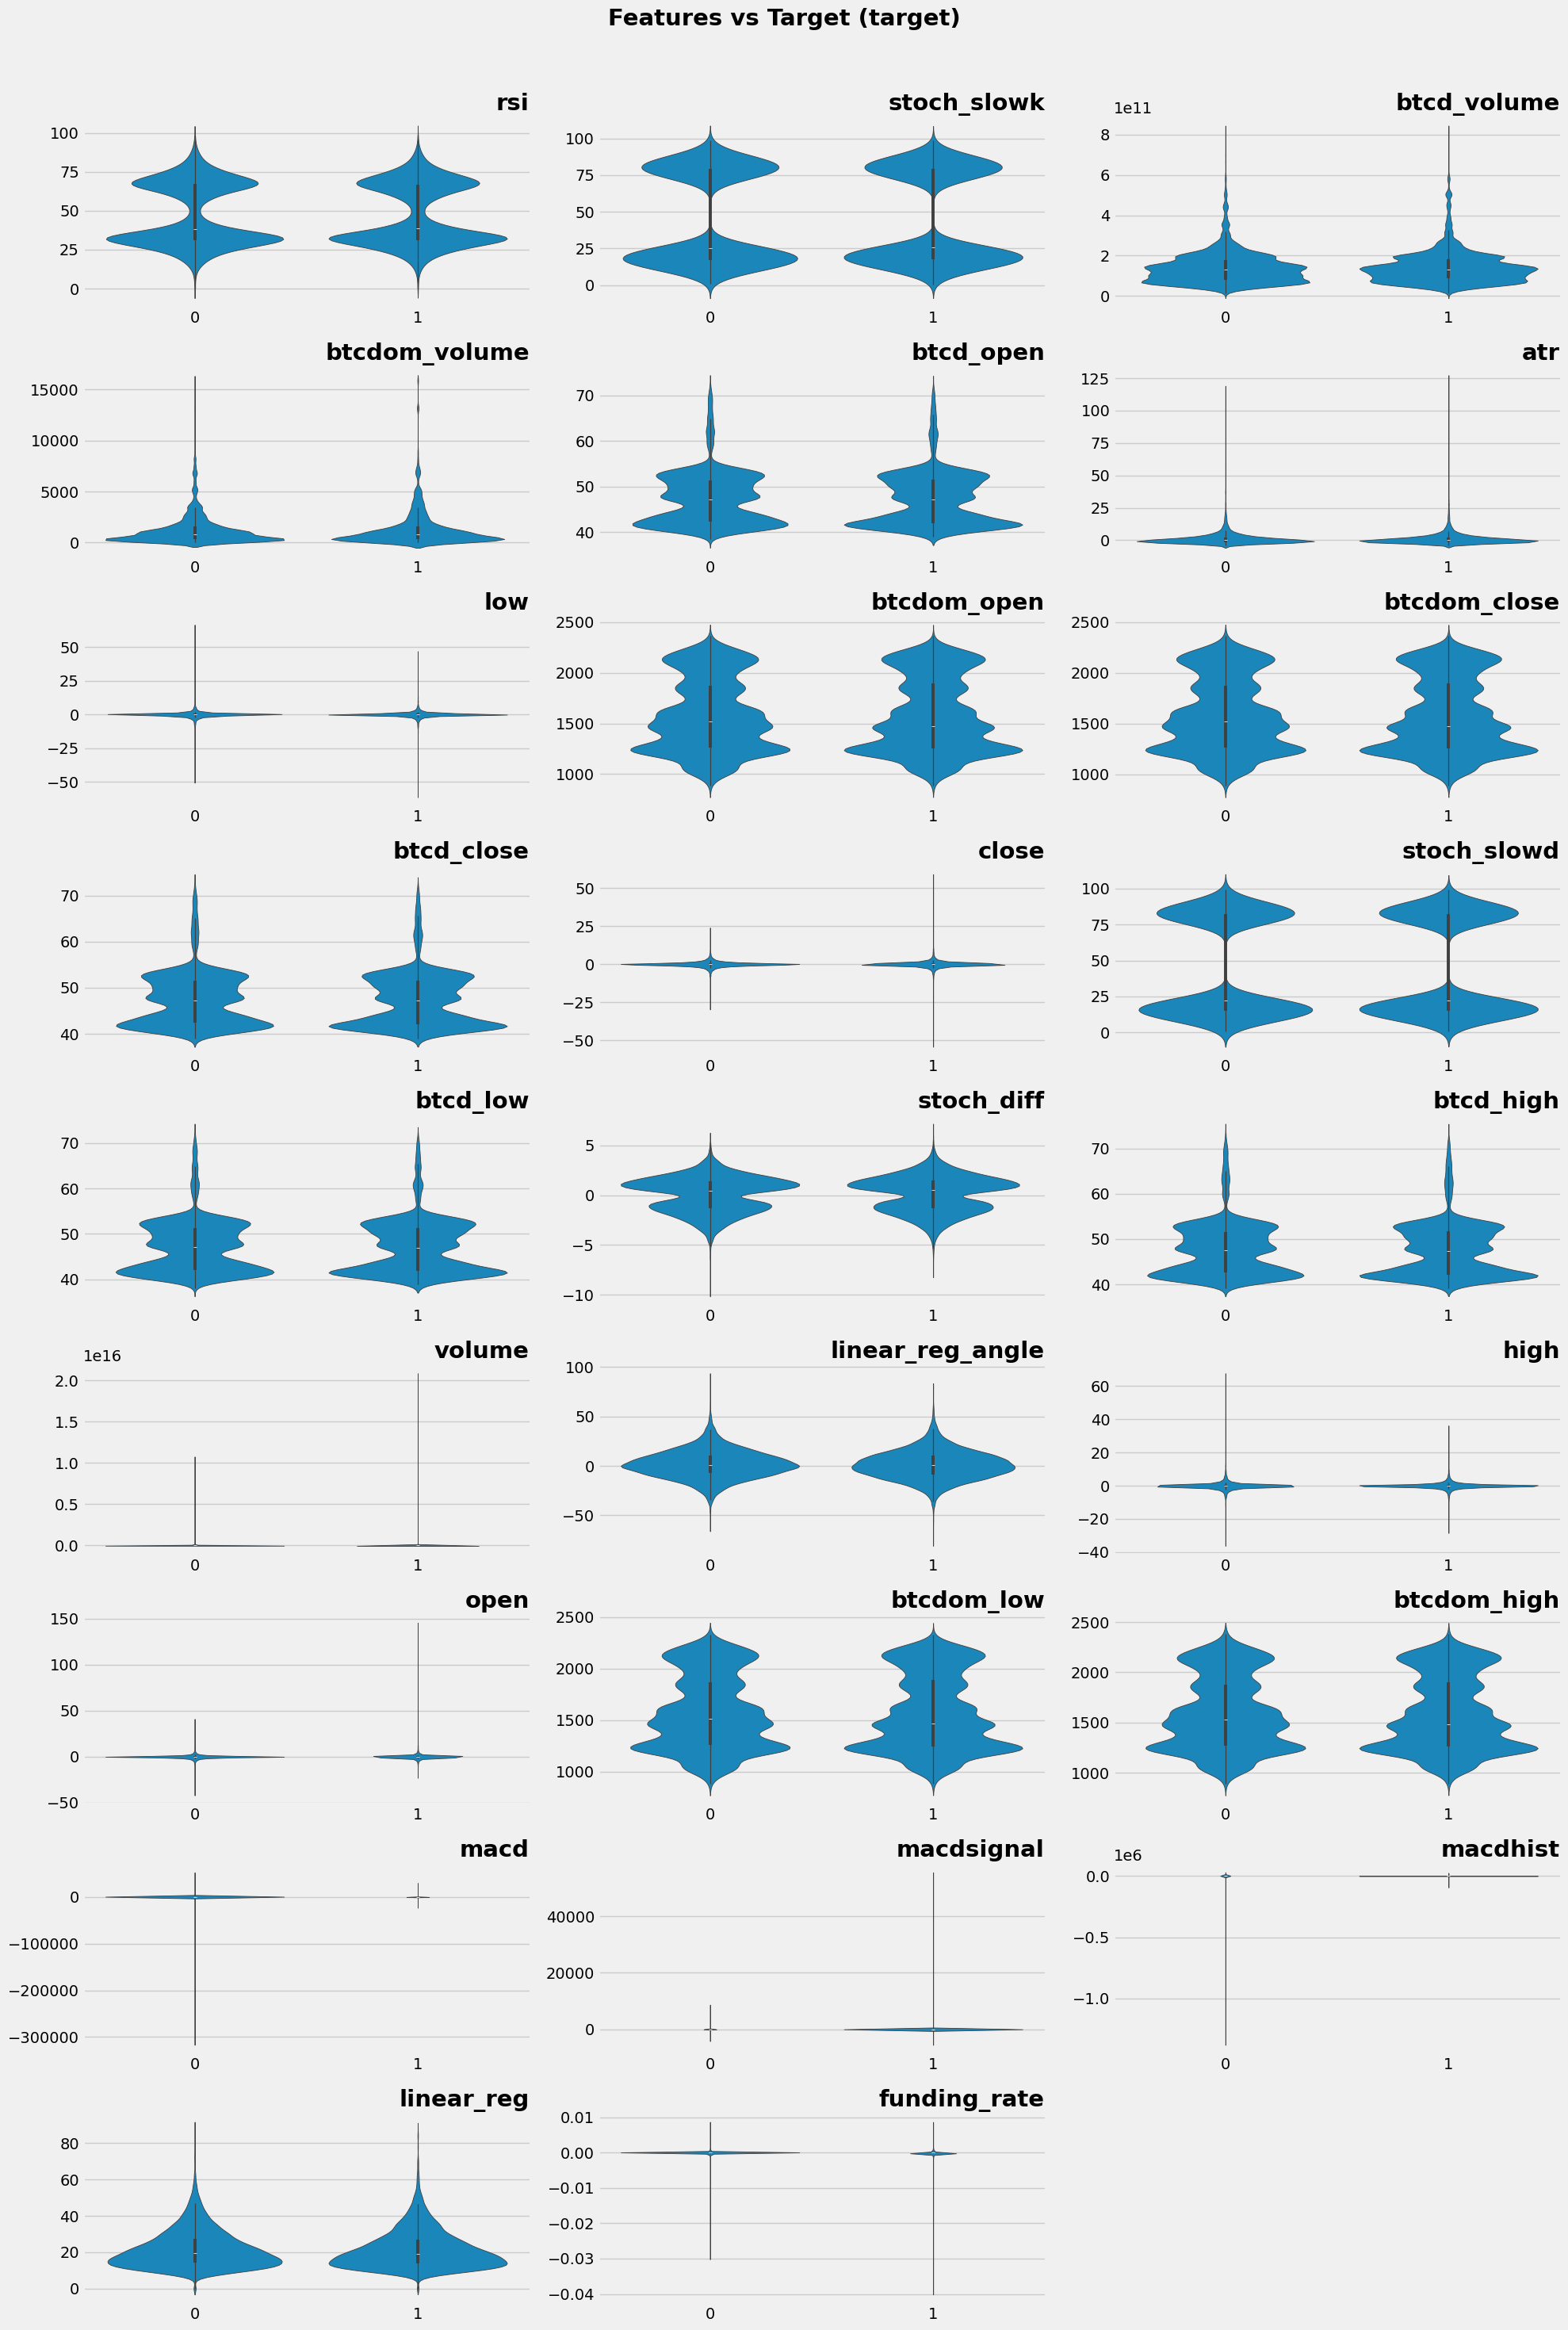

In [17]:
fi = pd.read_csv(f'feature_importance.csv')['Feature'].to_list()
cols = [c for c in fi if 'prev' not in c]
figsize = (20, 30)

def plot_target_violine(df, df_cols, n_rows, n_cols, target):
    fig = plt.figure(figsize=figsize)
    
    for idx, col in enumerate(df_cols):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        try:
            sns.violinplot(x=target, y=col, data=df)
        except ValueError:
            print(f"Can't find {col} in the dataframe")

        ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
        ax.set_xlabel(''); ax.spines['right'].set_visible(False)
        ax.set_title(f'{col}', loc='right', weight='bold', fontsize=21)

    
    fig.suptitle(f'Features vs Target ({target})\n\n\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
n_cols = 3
n_rows = len(cols) // n_cols + 1
plot_target_violine(train_df, cols, n_rows=n_rows, n_cols=n_cols, target='target') 

### Show the last signals

In [18]:
x = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
x['ttype'] = 'buy'
y = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
y['ttype'] = 'sell'
x = pd.concat([x, y]).sort_values('time').reset_index(drop=True)
x.loc[x['pattern'] == 'STOCH_RSI_Volume24', ['time', 'ticker', 'ttype', 'pattern']].tail(30)

,time,ticker,ttype,pattern
74291,2024-03-03 15:00:00,JAMUSDT,buy,STOCH_RSI_Volume24
74292,2024-03-03 16:00:00,STITCHUSDT,buy,STOCH_RSI_Volume24
74293,2024-03-03 16:00:00,MWCCUSDT,sell,STOCH_RSI_Volume24
74294,2024-03-03 17:00:00,GLMUSDT,sell,STOCH_RSI_Volume24
74295,2024-03-03 17:00:00,FDUSDUSDT,sell,STOCH_RSI_Volume24
74296,2024-03-03 17:00:00,POKTUSDT,buy,STOCH_RSI_Volume24
74297,2024-03-03 17:00:00,TSUKAUSDT,buy,STOCH_RSI_Volume24
74298,2024-03-03 18:00:00,NUMUSDT,sell,STOCH_RSI_Volume24
74299,2024-03-03 19:00:00,SOCUSDT,sell,STOCH_RSI_Volume24
74300,2024-03-03 19:00:00,FONCOINUSDT,buy,STOCH_RSI_Volume24


# Feature selection

### Select features with BORUTA feature importance

In [19]:
from shaphypetune import BoostBoruta
  
params = {
          'boosting_type': 'dart',
          'n_estimators': 1000,
          'learning_rate': 0.02,
          'max_depth': 10,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'gain',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-7,
          'objective': 'binary',
          'metric': 'average_precision'
        }
features = [c for c in train_df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]



def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df['target'], df['time']

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = 'logloss'

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f'Fold: {fold}')
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False, max_iter=1000)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],  
                  eval_metric='logloss', 
                  callbacks=[lgb.log_evaluation(100)])

        boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values('importance')
    boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(train_df)

### Select features with permutation importance and GBM feature importance

In [20]:
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for fold in range(CFG.n_repeats):
        print(f'Repeat {blu}#{fold+1}')

        X, y, time = df[features], df['target'], df['time']
        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        eval_metric = 'logloss'
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric=eval_metric, 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(train_df, permut=True)

### RFE feature selection

In [21]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          'penalty': 'l2',
          'max_iter': 10000,
          'C': 1
        }

    scaler = StandardScaler()
    X, y = df[features], df['target']
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=5, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({'importance': selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({'index': 'Feature'}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(train_df)

### Combine importances and save them

In [22]:
if CFG.select_features:
    # boruta_df_['rank'] = boruta_df_['importance'].rank()
    perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
    rfe_df_['rank'] = rfe_df_['importance']
    feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

    fi = pd.concat([perm_df_[['Feature','rank']], feature_importances_[['Feature','rank']], rfe_df_[['Feature','rank']]])
                    # boruta_df_[['Feature','rank']]])
    fi = fi.groupby('Feature')['rank'].sum().sort_values().reset_index()
    fi.to_csv(f'feature_importance.csv')
else:
    fi = pd.read_csv(f'feature_importance.csv')

### Load selected features

In [23]:
def prepare_features(fi, feature_num, features_to_exclude):
    ''' Get features, sort them by their time appearance and return for using in train and inference'''
    # exclude some features 
    fi = fi['Feature']
    fi = [f for f in fi if f not in features_to_exclude]
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == 'volume_24':
            feature_dict[0].append(f)
            continue
        period = f.split('_')
        if period[-1].isdigit():
            feature_dict[int(period[-1])].append('_'.join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f'_prev_{item[0]}' for i in item[1]])
        else:
            features.extend([i for i in item[1]])

    feature_dict['features'] = features # + ['Pattern_Trend', 'STOCH_RSI']

    return features, feature_dict

train_df['weekday'] = train_df['time'].dt.weekday
fi = pd.read_csv(f'feature_importance.csv')
feature_num = 115
features_to_exclude = []
features, feature_dict = prepare_features(fi, feature_num, features_to_exclude)
features = features + ['weekday']
display(features)

['rsi',
 'stoch_slowk',
 'btcd_volume',
 'btcdom_volume',
 'btcd_open',
 'atr',
 'low',
 'btcdom_volume_prev_4',
 'rsi_prev_4',
 'stoch_diff_prev_4',
 'btcdom_high_prev_4',
 'linear_reg_angle_prev_4',
 'stoch_slowk_prev_8',
 'low_prev_8',
 'linear_reg_angle_prev_8',
 'low_prev_12',
 'linear_reg_angle_prev_16',
 'stoch_slowk_prev_16',
 'btcdom_volume_prev_24',
 'low_prev_24',
 'stoch_diff_prev_28',
 'low_prev_32',
 'btcdom_volume_prev_32',
 'high_prev_32',
 'stoch_diff_prev_32',
 'btcdom_volume_prev_40',
 'rsi_prev_40',
 'btcdom_volume_prev_44',
 'close_prev_44',
 'btcd_volume_prev_48',
 'high_prev_48',
 'stoch_slowd_prev_48',
 'close_prev_48',
 'btcdom_volume_prev_52',
 'btcdom_volume_prev_56',
 'btcdom_volume_prev_60',
 'btcdom_volume_prev_64',
 'atr_prev_64',
 'btcdom_volume_prev_68',
 'rsi_prev_68',
 'stoch_slowd_prev_68',
 'rsi_prev_72',
 'btcdom_volume_prev_72',
 'open_prev_72',
 'high_prev_72',
 'btcdom_volume_prev_80',
 'high_prev_80',
 'btcdom_volume_prev_84',
 'low_prev_84',
 

### Show the features that correlate with other features too much (corr >= 0.8) and are not too important

In [24]:
if CFG.select_features:
    features_to_select = features.copy()
    correlations = train_df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']] 
    correlations.columns = ['feature_1', 'feature_2', 'corr']

    correlations = pd.merge(left=correlations, right=fi, how='left', left_on='feature_1', right_on='Feature')
    correlations = correlations.drop(columns='Feature')
    correlations = correlations.sort_values(['rank', 'feature_1'])

    features_to_exclude = list()
    corr_thresh = 0.8

    for i, row in correlations.iterrows():
        feature_1 = row['feature_1']
        feature_2 = row['feature_2']
        corr = row['corr']

        if feature_1 in features_to_exclude:
            continue

        if corr > corr_thresh:
            features_to_exclude.append(feature_2)

    display(set(features_to_exclude))

# Train

### Functions for train and optimization

In [45]:
val_idxs = list()
prec_score_list = list()
with open(f'bybit_tickers.json', 'r') as f:
    bybit_tickers = json.load(f)

def confident_score(y, oof, low_bound, high_bound):
    ''' Consider only high confident objects for accuracy and precision scores calculation;
        object probability must be lower than low_bound or higher than high_bound '''
    pred_conf = np.zeros_like(oof)
    pred_conf[oof > high_bound] = 1
    pred_conf_prec = pred_conf[(oof > high_bound)]
    y_conf_prec = y.values.reshape(-1,1)[(oof > high_bound)]
    if y_conf_prec.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf_prec, pred_conf_prec), y_conf_prec.shape[0], y_conf_prec.shape[0]/y.shape[0]

def model_train(df, features, params, n_folds, low_bound, high_bound, train_test, verbose=False): 
    X, time = df[features], df['time']
    y = df['target']
    
    if train_test == 'fold':
        oof = np.zeros([len(df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_folds, test_size=(len(df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_time = time[fit_idx].max() + pd.to_timedelta(96, unit='h')
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_time) & (df['ticker'].isin(bybit_tickers))].index.tolist()
            
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f'Fold #{fold + 1}')
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(df.loc[val_idx[0], 'time'])
                display(df.loc[val_idx[-1], 'time'])
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric='logloss', callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
        
            val_score = log_loss(y_val, val_preds)
            prec_score, prec_obj_num, prec_obj_pct = confident_score(y_val, val_preds[:, 1], low_bound, high_bound)
            prec_score_list.append(prec_score)
            if verbose:
                print(f'Logloss: {val_score}, Confident objects precision: {prec_score}\n'
                      f'Number of confident objects {prec_obj_num}, % of confident objects: {prec_obj_pct}\n'
                      f'Number of profitable objects: {round((2 * prec_score -  1) * prec_obj_num)}')
            oof[val_idx, 0] = val_preds[:,1]
        
        return oof, model_lgb, sorted(list(set(val_idxs)))
    elif train_test == 'full':
        print('Train on full data')
        X, y = df[features], df['target']
        
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, eval_set=[(X, y)], eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
        
        return np.zeros([df.shape[0], 1]), model_lgb, None

def objective(trial):
    params = {
        # Main parameters
#                     'device': 'gpu',
#                     'gpu_platform_id': 0,
#                     'gpu_device_id': 0,
        'objective': 'binary',
        'metric': 'average_precision',
        'boosting_type': trial.suggest_categorical('boosting_type', ['dart', 'goss', 'gbdt']),   
        # Hyperparamters (in order of importance decreasing)
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),  # max number of trees in model
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 3e-1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        'max_depth': trial.suggest_int('max_depth', 4, 10),   # tree max depth 
         # decrease to deal with overfit
        'num_leaves': trial.suggest_int('num_leaves', 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        'max_bin': trial.suggest_int('max_bin', 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        'subsample_freq': 1, # Perform bagging at every k iteration, alias: bagging_freq

#           'subsample_for_bin': 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                     # to larger value will give better training result but may increase train time 
#           'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                       # categorical features, especially for 
                                                                       # categories with few data
        'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False]),                                                        
        'verbose': -1,
        
        'high_bound': 0.5,
        'feature_num': trial.suggest_int('feature_num', 50, 500),
        'importance_type': 'gain'
    }

    if params['is_unbalance'] is True:
        params['class_weight'] = 'balanced'
    
    if params['boosting_type'] != 'goss':
        params['subsample'] = trial.suggest_float('subsample', 0.3, 0.9)

    high_bound = params['high_bound']
    low_bound = 1 - high_bound
    del params['high_bound']
    
    fi = pd.read_csv(f'feature_importance.csv')
    feature_num = params['feature_num']
    del params['feature_num']
    
    train_df['weekday'] = train_df['time'].dt.weekday
    features_to_exclude = list()
    features, _ = prepare_features(fi, feature_num, features_to_exclude)
    features = features + ['weekday']
    
    oof, __, val_idxs = model_train(train_df, features, params, n_folds=8, low_bound=low_bound, high_bound=high_bound, 
                                    train_test='fold')
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
    oof_val_score = log_loss(y, oof)
    res = oof_conf_obj_num * (oof_conf_prec_score-0.55) * 100
    # save dataframe with additional information
    df_optuna_more_info = pd.read_csv('optuna_lgbm_info.csv')
    profit_objects = round(oof_conf_obj_num * (2 * oof_conf_prec_score - 1))
    tmp = pd.DataFrame({'value': [res], 'oof_conf_prec_score': [oof_conf_prec_score], 
                        'profit_objects': [profit_objects], 'oof_val_score': [oof_val_score], 
                        'oof_conf_obj_num': [oof_conf_obj_num], 'oof_conf_obj_pct': [oof_conf_obj_pct], 
                        })
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv('optuna_lgbm_info.csv', index=False)
    return res

### Train / optimize process

In [46]:
params = {
            'boosting_type': 'dart',
            'n_estimators': 750,
            'learning_rate': 0.002475397350873312,
            'is_unbalance': True,
            'class_weight': 'balanced',
            'colsample_bytree': 0.7750876449084858,
            'subsample': 0.414290369845207,
            'max_depth': 4,
            'num_leaves': 111,
            'max_bin': 39,
            'reg_alpha': 0.005234459820643483,
            'reg_lambda': 9.676789942808846,
            'subsample_freq': 1,
            'objective': 'binary',
            'importance_type': 'gain',
            'metric': 'average_precision',
            'verbosity': -1
        }

# params = {
#             'boosting_type': 'gbdt',
#             'n_estimators': 981,
#             'learning_rate': 0.000704494362894,
#             'is_unbalance': True,
#             'class_weight': 'balanced',
#             'colsample_bytree': 0.6866010952449154,
#             'subsample': 0.4389198432764489,
#             'max_depth': 4,
#             'num_leaves': 35,
#             'max_bin': 58,
#             'reg_alpha': 0.0002065499898305,
#             'reg_lambda': 4.257519867834792e-05,
#             'subsample_freq': 1,
#             'objective': 'binary',
#             'importance_type': 'gain',
#             'metric': 'average_precision',
#             'verbosity': -1
#         }

train_test = 'fold' # fold, full
high_bound = 0.5
low_bound = 1 - high_bound
last_date = '2024-01-28'

if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=['value', 'oof_conf_prec_score', 'profit_objects', 
                                                'oof_val_score', 'oof_conf_obj_num', 'oof_conf_obj_pct'])
    df_optuna_more_info.to_csv('optuna_lgbm_info.csv', index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=500)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values('value', ascending=False)
    df_optuna.to_csv(f'optuna_lgbm.csv')

    display(df_optuna.head(10))
elif train_test == 'fold':
    # fold
    oof, _, val_idxs = model_train(train_df, features, params, n_folds=8, low_bound=low_bound, high_bound=high_bound, 
                                   train_test=train_test, verbose=True)
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_val_score = log_loss(y, oof)
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)

    print(f'Total fold Logloss: {oof_val_score}, Total confident objects precision: {oof_conf_prec_score}\n'
            f'Number of confident objects: {oof_conf_obj_num}, Total % of confident objects: {oof_conf_obj_pct}\n' 
            f'Number of profitable objects: {round(( 2 * oof_conf_prec_score - 1) * oof_conf_obj_num)}')
elif train_test == 'full': 
    oof, model, val_idxs = model_train(train_df[train_df['time'] < last_date], features, params, n_folds=5, low_bound=low_bound, 
                                       high_bound=high_bound, train_test=train_test, verbose=True)
    joblib.dump(model, f'lgbm.pkl') 
    # save feature dictionary for further inference
    with open(f'features.json', 'w') as f:
        json.dump(feature_dict, f)

Training with 116 features
Fold #1


1    0.540329
0    0.459671
Name: target, dtype: float64

Timestamp('2022-07-08 22:00:00')

Timestamp('2024-03-03 17:00:00')

[100]	training's binary_logloss: 0.686682	training's average_precision: 0.728174	valid_1's binary_logloss: 0.692394	valid_1's average_precision: 0.585111
[200]	training's binary_logloss: 0.683262	training's average_precision: 0.729232	valid_1's binary_logloss: 0.692154	valid_1's average_precision: 0.585603
[300]	training's binary_logloss: 0.679556	training's average_precision: 0.733012	valid_1's binary_logloss: 0.691823	valid_1's average_precision: 0.586079
[400]	training's binary_logloss: 0.675876	training's average_precision: 0.735778	valid_1's binary_logloss: 0.691757	valid_1's average_precision: 0.582218
[500]	training's binary_logloss: 0.672061	training's average_precision: 0.740988	valid_1's binary_logloss: 0.69204	valid_1's average_precision: 0.582894
[600]	training's binary_logloss: 0.670319	training's average_precision: 0.741657	valid_1's binary_logloss: 0.691899	valid_1's average_precision: 0.583134
[700]	training's binary_logloss: 0.667514	training's average_precision: 0.746

1    0.54302
0    0.45698
Name: target, dtype: float64

Timestamp('2022-10-01 22:00:00')

Timestamp('2024-03-03 17:00:00')

[100]	training's binary_logloss: 0.687512	training's average_precision: 0.710189	valid_1's binary_logloss: 0.692407	valid_1's average_precision: 0.594433
[200]	training's binary_logloss: 0.684403	training's average_precision: 0.717616	valid_1's binary_logloss: 0.69211	valid_1's average_precision: 0.591645
[300]	training's binary_logloss: 0.680875	training's average_precision: 0.721353	valid_1's binary_logloss: 0.691826	valid_1's average_precision: 0.586242
[400]	training's binary_logloss: 0.677523	training's average_precision: 0.723075	valid_1's binary_logloss: 0.691229	valid_1's average_precision: 0.581719
[500]	training's binary_logloss: 0.674048	training's average_precision: 0.725873	valid_1's binary_logloss: 0.69112	valid_1's average_precision: 0.588869
[600]	training's binary_logloss: 0.672334	training's average_precision: 0.72819	valid_1's binary_logloss: 0.691069	valid_1's average_precision: 0.589519
[700]	training's binary_logloss: 0.669583	training's average_precision: 0.73075

1    0.536744
0    0.463256
Name: target, dtype: float64

Timestamp('2023-01-29 22:00:00')

Timestamp('2024-03-03 17:00:00')

[100]	training's binary_logloss: 0.687697	training's average_precision: 0.708984	valid_1's binary_logloss: 0.692051	valid_1's average_precision: 0.571596
[200]	training's binary_logloss: 0.684766	training's average_precision: 0.715094	valid_1's binary_logloss: 0.691959	valid_1's average_precision: 0.561592
[300]	training's binary_logloss: 0.681378	training's average_precision: 0.717097	valid_1's binary_logloss: 0.691515	valid_1's average_precision: 0.565981
[400]	training's binary_logloss: 0.678206	training's average_precision: 0.719678	valid_1's binary_logloss: 0.69124	valid_1's average_precision: 0.562774
[500]	training's binary_logloss: 0.674889	training's average_precision: 0.722856	valid_1's binary_logloss: 0.691238	valid_1's average_precision: 0.56225
[600]	training's binary_logloss: 0.673335	training's average_precision: 0.724341	valid_1's binary_logloss: 0.691151	valid_1's average_precision: 0.560017
[700]	training's binary_logloss: 0.670712	training's average_precision: 0.7265

1    0.544039
0    0.455961
Name: target, dtype: float64

Timestamp('2023-04-20 21:00:00')

Timestamp('2024-03-03 17:00:00')

[100]	training's binary_logloss: 0.687854	training's average_precision: 0.705451	valid_1's binary_logloss: 0.692936	valid_1's average_precision: 0.578337
[200]	training's binary_logloss: 0.684983	training's average_precision: 0.708868	valid_1's binary_logloss: 0.693132	valid_1's average_precision: 0.570705
[300]	training's binary_logloss: 0.681829	training's average_precision: 0.711562	valid_1's binary_logloss: 0.693075	valid_1's average_precision: 0.567298
[400]	training's binary_logloss: 0.678758	training's average_precision: 0.715431	valid_1's binary_logloss: 0.693371	valid_1's average_precision: 0.565701
[500]	training's binary_logloss: 0.675492	training's average_precision: 0.718922	valid_1's binary_logloss: 0.693565	valid_1's average_precision: 0.570884
[600]	training's binary_logloss: 0.674063	training's average_precision: 0.720771	valid_1's binary_logloss: 0.693974	valid_1's average_precision: 0.56727
[700]	training's binary_logloss: 0.67146	training's average_precision: 0.7223

1    0.565531
0    0.434469
Name: target, dtype: float64

Timestamp('2023-06-24 01:00:00')

Timestamp('2024-03-03 17:00:00')

[100]	training's binary_logloss: 0.687763	training's average_precision: 0.707253	valid_1's binary_logloss: 0.694465	valid_1's average_precision: 0.577765
[200]	training's binary_logloss: 0.684912	training's average_precision: 0.708656	valid_1's binary_logloss: 0.694744	valid_1's average_precision: 0.584252
[300]	training's binary_logloss: 0.681702	training's average_precision: 0.712328	valid_1's binary_logloss: 0.695486	valid_1's average_precision: 0.578245
[400]	training's binary_logloss: 0.678575	training's average_precision: 0.714804	valid_1's binary_logloss: 0.69618	valid_1's average_precision: 0.579523
[500]	training's binary_logloss: 0.675348	training's average_precision: 0.716933	valid_1's binary_logloss: 0.696645	valid_1's average_precision: 0.581474
[600]	training's binary_logloss: 0.673922	training's average_precision: 0.717702	valid_1's binary_logloss: 0.697171	valid_1's average_precision: 0.582777
[700]	training's binary_logloss: 0.671479	training's average_precision: 0.719

1    0.577911
0    0.422089
Name: target, dtype: float64

Timestamp('2023-09-12 14:00:00')

Timestamp('2024-03-03 17:00:00')

[100]	training's binary_logloss: 0.688466	training's average_precision: 0.701222	valid_1's binary_logloss: 0.694241	valid_1's average_precision: 0.604585
[200]	training's binary_logloss: 0.685945	training's average_precision: 0.703028	valid_1's binary_logloss: 0.694825	valid_1's average_precision: 0.616492
[300]	training's binary_logloss: 0.683084	training's average_precision: 0.707336	valid_1's binary_logloss: 0.695433	valid_1's average_precision: 0.598894
[400]	training's binary_logloss: 0.680216	training's average_precision: 0.711082	valid_1's binary_logloss: 0.695917	valid_1's average_precision: 0.595835
[500]	training's binary_logloss: 0.677254	training's average_precision: 0.712606	valid_1's binary_logloss: 0.696712	valid_1's average_precision: 0.60495
[600]	training's binary_logloss: 0.675964	training's average_precision: 0.71424	valid_1's binary_logloss: 0.696716	valid_1's average_precision: 0.605379
[700]	training's binary_logloss: 0.673638	training's average_precision: 0.7160

1    0.545958
0    0.454042
Name: target, dtype: float64

Timestamp('2023-11-25 19:00:00')

Timestamp('2024-03-03 17:00:00')

[100]	training's binary_logloss: 0.688978	training's average_precision: 0.691795	valid_1's binary_logloss: 0.693082	valid_1's average_precision: 0.628288
[200]	training's binary_logloss: 0.686739	training's average_precision: 0.696883	valid_1's binary_logloss: 0.693135	valid_1's average_precision: 0.628621
[300]	training's binary_logloss: 0.684354	training's average_precision: 0.698317	valid_1's binary_logloss: 0.693229	valid_1's average_precision: 0.623108
[400]	training's binary_logloss: 0.681952	training's average_precision: 0.700951	valid_1's binary_logloss: 0.693261	valid_1's average_precision: 0.622346
[500]	training's binary_logloss: 0.679312	training's average_precision: 0.703288	valid_1's binary_logloss: 0.693113	valid_1's average_precision: 0.628015
[600]	training's binary_logloss: 0.678191	training's average_precision: 0.704974	valid_1's binary_logloss: 0.693076	valid_1's average_precision: 0.624579
[700]	training's binary_logloss: 0.67619	training's average_precision: 0.706

1    0.547561
0    0.452439
Name: target, dtype: float64

Timestamp('2024-01-22 23:00:00')

Timestamp('2024-03-03 17:00:00')

[100]	training's binary_logloss: 0.68933	training's average_precision: 0.679287	valid_1's binary_logloss: 0.693339	valid_1's average_precision: 0.569824
[200]	training's binary_logloss: 0.687273	training's average_precision: 0.678924	valid_1's binary_logloss: 0.693251	valid_1's average_precision: 0.595294
[300]	training's binary_logloss: 0.685049	training's average_precision: 0.684629	valid_1's binary_logloss: 0.693517	valid_1's average_precision: 0.588978
[400]	training's binary_logloss: 0.682816	training's average_precision: 0.686044	valid_1's binary_logloss: 0.693651	valid_1's average_precision: 0.587174
[500]	training's binary_logloss: 0.680495	training's average_precision: 0.689178	valid_1's binary_logloss: 0.693673	valid_1's average_precision: 0.590559
[600]	training's binary_logloss: 0.679369	training's average_precision: 0.691052	valid_1's binary_logloss: 0.693885	valid_1's average_precision: 0.593201
[700]	training's binary_logloss: 0.677595	training's average_precision: 0.692

In [49]:
# Training with 116 features
# Fold #1
# 1    0.540329
# 0    0.459671
# Name: target, dtype: float64Timestamp('2022-07-08 22:00:00')Timestamp('2024-03-03 17:00:00')
# [100]	training's binary_logloss: 0.686682	training's average_precision: 0.728174	valid_1's binary_logloss: 0.692394	valid_1's average_precision: 0.585111
# [200]	training's binary_logloss: 0.683262	training's average_precision: 0.729232	valid_1's binary_logloss: 0.692154	valid_1's average_precision: 0.585603
# [300]	training's binary_logloss: 0.679556	training's average_precision: 0.733012	valid_1's binary_logloss: 0.691823	valid_1's average_precision: 0.586079
# [400]	training's binary_logloss: 0.675876	training's average_precision: 0.735778	valid_1's binary_logloss: 0.691757	valid_1's average_precision: 0.582218
# [500]	training's binary_logloss: 0.672061	training's average_precision: 0.740988	valid_1's binary_logloss: 0.69204	valid_1's average_precision: 0.582894
# [600]	training's binary_logloss: 0.670319	training's average_precision: 0.741657	valid_1's binary_logloss: 0.691899	valid_1's average_precision: 0.583134
# [700]	training's binary_logloss: 0.667514	training's average_precision: 0.746036	valid_1's binary_logloss: 0.692055	valid_1's average_precision: 0.582797
# Logloss: 0.692008206480719, Confident objects precision: 0.5740415054519873
# Number of confident objects 2843, % of confident objects: 0.3469188529591214
# Number of profitable objects: 421
# Fold #2
# 1    0.54302
# 0    0.45698
# Name: target, dtype: float64Timestamp('2022-10-01 22:00:00')Timestamp('2024-03-03 17:00:00')
# [100]	training's binary_logloss: 0.687512	training's average_precision: 0.710189	valid_1's binary_logloss: 0.692407	valid_1's average_precision: 0.594433
# [200]	training's binary_logloss: 0.684403	training's average_precision: 0.717616	valid_1's binary_logloss: 0.69211	valid_1's average_precision: 0.591645
# [300]	training's binary_logloss: 0.680875	training's average_precision: 0.721353	valid_1's binary_logloss: 0.691826	valid_1's average_precision: 0.586242
# [400]	training's binary_logloss: 0.677523	training's average_precision: 0.723075	valid_1's binary_logloss: 0.691229	valid_1's average_precision: 0.581719
# [500]	training's binary_logloss: 0.674048	training's average_precision: 0.725873	valid_1's binary_logloss: 0.69112	valid_1's average_precision: 0.588869
# [600]	training's binary_logloss: 0.672334	training's average_precision: 0.72819	valid_1's binary_logloss: 0.691069	valid_1's average_precision: 0.589519
# [700]	training's binary_logloss: 0.669583	training's average_precision: 0.730755	valid_1's binary_logloss: 0.690746	valid_1's average_precision: 0.590044
# Logloss: 0.6902621939549092, Confident objects precision: 0.5608238575413002
# Number of confident objects 4661, % of confident objects: 0.6499790824152838
# Number of profitable objects: 567
# Fold #3
# 1    0.536744
# 0    0.463256
# Name: target, dtype: float64Timestamp('2023-01-29 22:00:00')Timestamp('2024-03-03 17:00:00')
# [100]	training's binary_logloss: 0.687697	training's average_precision: 0.708984	valid_1's binary_logloss: 0.692051	valid_1's average_precision: 0.571596
# [200]	training's binary_logloss: 0.684766	training's average_precision: 0.715094	valid_1's binary_logloss: 0.691959	valid_1's average_precision: 0.561592
# [300]	training's binary_logloss: 0.681378	training's average_precision: 0.717097	valid_1's binary_logloss: 0.691515	valid_1's average_precision: 0.565981
# [400]	training's binary_logloss: 0.678206	training's average_precision: 0.719678	valid_1's binary_logloss: 0.69124	valid_1's average_precision: 0.562774
# [500]	training's binary_logloss: 0.674889	training's average_precision: 0.722856	valid_1's binary_logloss: 0.691238	valid_1's average_precision: 0.56225
# [600]	training's binary_logloss: 0.673335	training's average_precision: 0.724341	valid_1's binary_logloss: 0.691151	valid_1's average_precision: 0.560017
# [700]	training's binary_logloss: 0.670712	training's average_precision: 0.726558	valid_1's binary_logloss: 0.691	valid_1's average_precision: 0.560712
# Logloss: 0.6908665567028024, Confident objects precision: 0.556
# Number of confident objects 4250, % of confident objects: 0.6925207756232687
# Number of profitable objects: 476
# Fold #4
# 1    0.544039
# 0    0.455961
# Name: target, dtype: float64Timestamp('2023-04-20 21:00:00')Timestamp('2024-03-03 17:00:00')
# [100]	training's binary_logloss: 0.687854	training's average_precision: 0.705451	valid_1's binary_logloss: 0.692936	valid_1's average_precision: 0.578337
# [200]	training's binary_logloss: 0.684983	training's average_precision: 0.708868	valid_1's binary_logloss: 0.693132	valid_1's average_precision: 0.570705
# [300]	training's binary_logloss: 0.681829	training's average_precision: 0.711562	valid_1's binary_logloss: 0.693075	valid_1's average_precision: 0.567298
# [400]	training's binary_logloss: 0.678758	training's average_precision: 0.715431	valid_1's binary_logloss: 0.693371	valid_1's average_precision: 0.565701
# [500]	training's binary_logloss: 0.675492	training's average_precision: 0.718922	valid_1's binary_logloss: 0.693565	valid_1's average_precision: 0.570884
# [600]	training's binary_logloss: 0.674063	training's average_precision: 0.720771	valid_1's binary_logloss: 0.693974	valid_1's average_precision: 0.56727
# [700]	training's binary_logloss: 0.67146	training's average_precision: 0.722305	valid_1's binary_logloss: 0.694063	valid_1's average_precision: 0.572741
# Logloss: 0.6938175232911609, Confident objects precision: 0.5768463073852296
# Number of confident objects 1002, % of confident objects: 0.20524375256042607
# Number of profitable objects: 154
# Fold #5
# 1    0.565531
# 0    0.434469
# Name: target, dtype: float64Timestamp('2023-06-24 01:00:00')Timestamp('2024-03-03 17:00:00')
# [100]	training's binary_logloss: 0.687763	training's average_precision: 0.707253	valid_1's binary_logloss: 0.694465	valid_1's average_precision: 0.577765
# [200]	training's binary_logloss: 0.684912	training's average_precision: 0.708656	valid_1's binary_logloss: 0.694744	valid_1's average_precision: 0.584252
# [300]	training's binary_logloss: 0.681702	training's average_precision: 0.712328	valid_1's binary_logloss: 0.695486	valid_1's average_precision: 0.578245
# [400]	training's binary_logloss: 0.678575	training's average_precision: 0.714804	valid_1's binary_logloss: 0.69618	valid_1's average_precision: 0.579523
# [500]	training's binary_logloss: 0.675348	training's average_precision: 0.716933	valid_1's binary_logloss: 0.696645	valid_1's average_precision: 0.581474
# [600]	training's binary_logloss: 0.673922	training's average_precision: 0.717702	valid_1's binary_logloss: 0.697171	valid_1's average_precision: 0.582777
# [700]	training's binary_logloss: 0.671479	training's average_precision: 0.719677	valid_1's binary_logloss: 0.697409	valid_1's average_precision: 0.587041
# Logloss: 0.697567705247074, Confident objects precision: 0.6920152091254753
# Number of confident objects 263, % of confident objects: 0.06785345717234262
# Number of profitable objects: 101
# Fold #6
# 1    0.577911
# 0    0.422089
# Name: target, dtype: float64Timestamp('2023-09-12 14:00:00')Timestamp('2024-03-03 17:00:00')
# [100]	training's binary_logloss: 0.688466	training's average_precision: 0.701222	valid_1's binary_logloss: 0.694241	valid_1's average_precision: 0.604585
# [200]	training's binary_logloss: 0.685945	training's average_precision: 0.703028	valid_1's binary_logloss: 0.694825	valid_1's average_precision: 0.616492
# [300]	training's binary_logloss: 0.683084	training's average_precision: 0.707336	valid_1's binary_logloss: 0.695433	valid_1's average_precision: 0.598894
# [400]	training's binary_logloss: 0.680216	training's average_precision: 0.711082	valid_1's binary_logloss: 0.695917	valid_1's average_precision: 0.595835
# [500]	training's binary_logloss: 0.677254	training's average_precision: 0.712606	valid_1's binary_logloss: 0.696712	valid_1's average_precision: 0.60495
# [600]	training's binary_logloss: 0.675964	training's average_precision: 0.71424	valid_1's binary_logloss: 0.696716	valid_1's average_precision: 0.605379
# [700]	training's binary_logloss: 0.673638	training's average_precision: 0.716095	valid_1's binary_logloss: 0.697305	valid_1's average_precision: 0.60229
# Logloss: 0.6975105582764402, Confident objects precision: 0.6317365269461078
# Number of confident objects 334, % of confident objects: 0.11748153359127682
# Number of profitable objects: 88
# Fold #7
# 1    0.545958
# 0    0.454042
# Name: target, dtype: float64Timestamp('2023-11-25 19:00:00')Timestamp('2024-03-03 17:00:00')
# [100]	training's binary_logloss: 0.688978	training's average_precision: 0.691795	valid_1's binary_logloss: 0.693082	valid_1's average_precision: 0.628288
# [200]	training's binary_logloss: 0.686739	training's average_precision: 0.696883	valid_1's binary_logloss: 0.693135	valid_1's average_precision: 0.628621
# [300]	training's binary_logloss: 0.684354	training's average_precision: 0.698317	valid_1's binary_logloss: 0.693229	valid_1's average_precision: 0.623108
# [400]	training's binary_logloss: 0.681952	training's average_precision: 0.700951	valid_1's binary_logloss: 0.693261	valid_1's average_precision: 0.622346
# [500]	training's binary_logloss: 0.679312	training's average_precision: 0.703288	valid_1's binary_logloss: 0.693113	valid_1's average_precision: 0.628015
# [600]	training's binary_logloss: 0.678191	training's average_precision: 0.704974	valid_1's binary_logloss: 0.693076	valid_1's average_precision: 0.624579
# [700]	training's binary_logloss: 0.67619	training's average_precision: 0.706322	valid_1's binary_logloss: 0.693242	valid_1's average_precision: 0.62214
# Logloss: 0.6932518246580882, Confident objects precision: 0.70995670995671
# Number of confident objects 231, % of confident objects: 0.12790697674418605
# Number of profitable objects: 97
# Fold #8
# 1    0.547561
# 0    0.452439
# Name: target, dtype: float64Timestamp('2024-01-22 23:00:00')Timestamp('2024-03-03 17:00:00')
# [100]	training's binary_logloss: 0.68933	training's average_precision: 0.679287	valid_1's binary_logloss: 0.693339	valid_1's average_precision: 0.569824
# [200]	training's binary_logloss: 0.687273	training's average_precision: 0.678924	valid_1's binary_logloss: 0.693251	valid_1's average_precision: 0.595294
# [300]	training's binary_logloss: 0.685049	training's average_precision: 0.684629	valid_1's binary_logloss: 0.693517	valid_1's average_precision: 0.588978
# [400]	training's binary_logloss: 0.682816	training's average_precision: 0.686044	valid_1's binary_logloss: 0.693651	valid_1's average_precision: 0.587174
# [500]	training's binary_logloss: 0.680495	training's average_precision: 0.689178	valid_1's binary_logloss: 0.693673	valid_1's average_precision: 0.590559
# [600]	training's binary_logloss: 0.679369	training's average_precision: 0.691052	valid_1's binary_logloss: 0.693885	valid_1's average_precision: 0.593201
# [700]	training's binary_logloss: 0.677595	training's average_precision: 0.692629	valid_1's binary_logloss: 0.693829	valid_1's average_precision: 0.588814
# Logloss: 0.6937740007507547, Confident objects precision: 0.6379310344827587
# Number of confident objects 174, % of confident objects: 0.2121951219512195
# Number of profitable objects: 48
# Total fold Logloss: 0.6927175331164498, Total confident objects precision: 0.6313213703099511
# Number of confident objects: 1839, Total % of confident objects: 0.224405125076266
# Number of profitable objects: 483

### Visualize train results

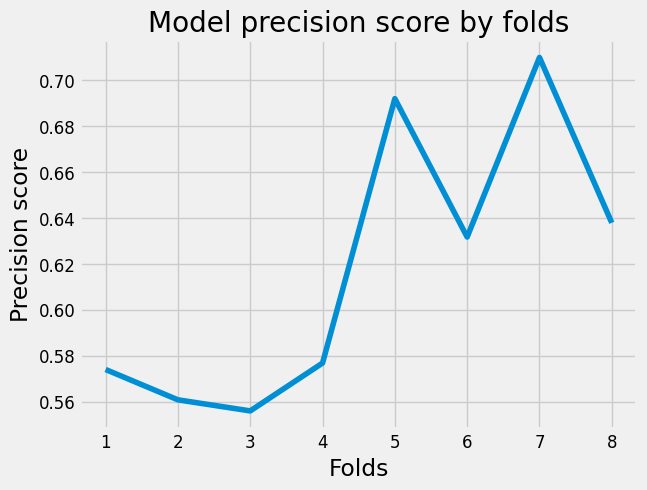

In [47]:
if not CFG.optimize and train_test == 'fold':
    sns.lineplot(x=list(range(1, 9)), y=prec_score_list)

    plt.title('Model precision score by folds')
    plt.xlabel('Folds')
    plt.xticks(fontsize=12)
    plt.ylabel('Precision score')
    plt.yticks(fontsize=12)

    plt.show()

### Distribution of model prediction scores

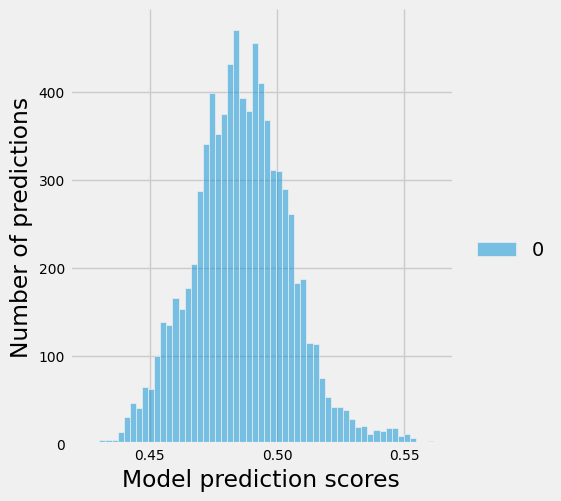

In [48]:
if not CFG.optimize and train_test == 'fold':
    sns.displot(oof)

    plt.xlabel('Model prediction scores')
    plt.xticks(fontsize=10)
    plt.ylabel('Number of predictions')
    plt.yticks(fontsize=10)

# Test model

### Test model predictions on the new data

In [50]:
if not CFG.optimize and train_test == 'full':
    model_lgb = joblib.load('lgbm.pkl')

    with open(f'bybit_tickers.json', 'r') as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df['ticker'].isin(bybit_tickers))]
    X['pred'] = model_lgb.predict_proba(X[features])[:,1]
    res = X.loc[(X['pred'] >= high_bound) & (X['time'] >= last_date), ['time', 'ticker', 'ttype', 'pred', 'target', 'pattern']]
    display(res['time'].min(), res['time'].max())
    display(res['target'].value_counts())
    display(res['target'].value_counts(normalize=True))

In [51]:
# 1    84
# 0    53
# Name: target, dtype: int641    0.613139
# 0    0.386861
# Name: target, dtype: float64

### Display PR curve

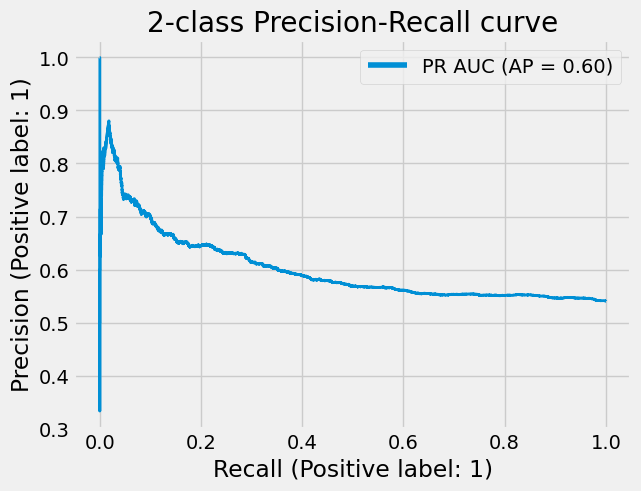

In [52]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == 'fold':
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    plt.legend(loc='upper right')
    _ = disp.ax_.set_title("2-class Precision-Recall curve")
    disp.ax_.lines[0].set_linewidth(2)

# vol 1e6 AP=0.61

### Find the best threshold

ic| bound: 0.3
    prec_score: 0.54033
    obj_num: 8195
    obj_pct: 1.0
    obj_profit: 661
ic| bound: 0.31
    prec_score: 0.54033
    obj_num: 8195
    obj_pct: 1.0
    obj_profit: 661
ic| bound: 0.32
    prec_score: 0.54033
    obj_num: 8195
    obj_pct: 1.0
    obj_profit: 661
ic| bound: 0.33
    prec_score: 0.54033
    obj_num: 8195
    obj_pct: 1.0
    obj_profit: 661
ic| bound: 0.34
    prec_score: 0.54033
    obj_num: 8195
    obj_pct: 1.0
    obj_profit: 661
ic| bound: 0.35
    prec_score: 0.54033
    obj_num: 8195
    obj_pct: 1.0
    obj_profit: 661
ic| bound: 0.36
    prec_score: 0.54033
    obj_num: 8195
    obj_pct: 1.0
    obj_profit: 661
ic| bound: 0.37
    prec_score: 0.54033
    obj_num: 8195
    obj_pct: 1.0
    obj_profit: 661
ic| bound: 0.38
    prec_score: 0.54033
    obj_num: 8195
    obj_pct: 1.0
    obj_profit: 661
ic| bound: 0.39
    prec_score: 0.54033
    obj_num: 8195
    obj_pct: 1.0
    obj_profit: 661
ic| bound: 0.4
    prec_score: 0.54033
    obj_num:

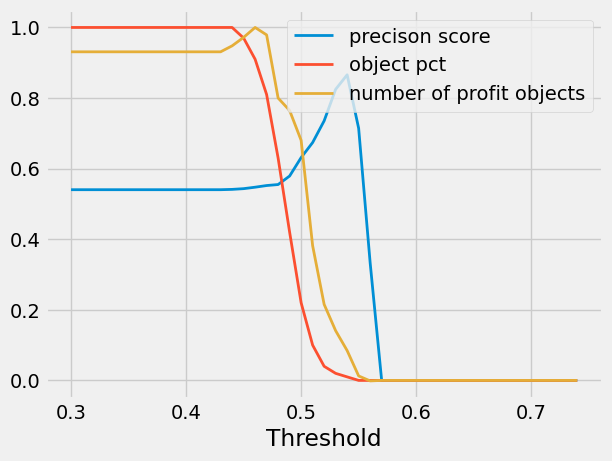

In [53]:
from icecream import ic

if not CFG.optimize and train_test == 'fold':
    prec_score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.3, 0.75, 0.01):
        prec_score, obj_num, obj_pct = confident_score(y.reset_index(drop=True), oof, 1-hb, hb)
        if prec_score == 0:
            obj_num = 0
            obj_pct = 0
        bound, prec_score, obj_num, obj_pct = round(hb, 2), round(prec_score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round((2 * prec_score - 1) * obj_num)
        prec_score_list.append(prec_score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, prec_score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.3, 0.75, 0.01), prec_score_list, label='precison score', linewidth=2)
    line2 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_pct_list, label='object pct', linewidth=2)
    line3 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_profit_list, label='number of profit objects', linewidth=2)
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

# Compare indicator / signal values for bot and optimizer

In [54]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = 'buy'
# ticker = 'METHUSDT'
# month = 1
# day = 25
# hour = 6
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)
# y = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_3.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, '', '', 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, '', '', 0)

# # cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'stoch_slowk', 'stoch_slowd', 'linear_reg', 'linear_reg_angle', 'macd', 'macdsignal', 'macdhist']
# cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'linear_reg', 'linear_reg_angle', 'high_max', 'low_min', 'volume_24']

# higher_features = ['time_4h', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist',  'macd_dir', 
#                    'macdsignal', 'macdsignal_dir']
# y['time_4h'] = y['time'] + pd.to_timedelta(3, unit='h')
# x[['time'] + higher_features] = pd.merge(x[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# x.drop(columns=['time_4h'], inplace=True)
# y.drop(columns=['time_4h'], inplace=True)
# x.ffill(inplace=True)
# x.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
# v = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, '', '', 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, '', '', 0)
# z.tail(48)

# v['time_4h'] = v['time'] + pd.to_timedelta(3, unit='h')
# z[['time'] + higher_features] = pd.merge(z[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# z.drop(columns=['time_4h'], inplace=True)
# v.drop(columns=['time_4h'], inplace=True)
# z.ffill(inplace=True)
# z.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols][-1:])